# Age from face
Predict age of a person from an image of their face

### Project Repo 
https://github.com/buckcri/age-from-face

## Participants:
Oskar Lachnit, Florian Diedrich, Nils-Christian Buck

### Course and Semester
Deep Learning from Scratch, WiSe2122

### License
Not yet decided

---

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data/face_age"

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
batch_size = 32

#Fix seed to achieve determinism
fixed_seed = 42

#10% of data reserved for validation set
validation_split=0.1

#Load both training and validation set. Sets are shuffled by default
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=fixed_seed,
  image_size=(100, 100),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=fixed_seed,
  image_size=(100, 100),
  batch_size=batch_size)


Found 9778 files belonging to 99 classes.
Using 8801 files for training.


2021-12-20 17:18:55.544579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-20 17:18:55.544600: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 17:18:55.544617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (39051fad144a): /proc/driver/nvidia/version does not exist
2021-12-20 17:18:55.547293: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 9778 files belonging to 99 classes.
Using 977 files for validation.


In [5]:
#Labels
class_names = train_ds.class_names
print(class_names)
#Elements of dataset
print(train_ds.element_spec)
print(train_ds)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']
(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
<BatchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>


2021-12-20 17:18:56.006755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


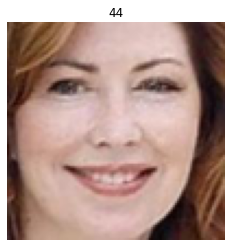

In [6]:
#Show one random image from dataset, including label

example_batch = train_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

example_image = x[0]
example_label = y[0]

plt.imshow(example_image.numpy().astype("uint8"))
plt.title(example_label.numpy())
plt.axis("off")
plt.show()

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 100, 100, 3)
(32,)


In [8]:
#Count the number of examples for each label
from collections import defaultdict

age_dist = defaultdict(int)

for x_batch,y_batch in train_ds.as_numpy_iterator():
   for i in range(len(y_batch)):
       age_dist[y_batch[i]] += 1


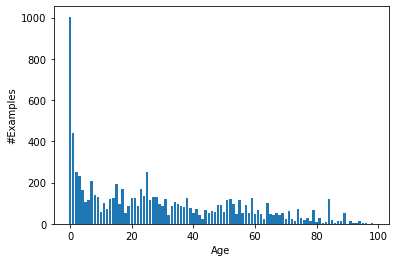

In [9]:
#Plot above count
plt.bar(list(age_dist.keys()), age_dist.values())
plt.xlabel('Age')
plt.ylabel('#Examples')
plt.show()

In [10]:
#Number of distinct labels:
num_labels = len(list(age_dist.keys()))

print(num_labels)

99


In [19]:
# Define DNN with hidden layers. Rescale pixel values to [0, 1] first.
# There's one output class for each label.
# @see https://www.tensorflow.org/api_docs/python/tf/keras/layers

num_classes = num_labels

#Do not define activation function on output layer as recommended by TF documentation.
#Activation from using from_logits=True in loss function may offer better numerical stability.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#SparseCategoricalCrossentropy is to be used with integer labels (versus one-hot representation)
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])

In [62]:
#Train model

epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print(model.summary())

Epoch 1/50
276/276 [==============================] - 7s 25ms/step - loss: 3.4343 - accuracy: 0.1563 - top_k_categorical_accuracy: 0.2893 - val_loss: 3.6190 - val_accuracy: 0.1290 - val_top_k_categorical_accuracy: 0.2170
Epoch 2/50
276/276 [==============================] - 7s 25ms/step - loss: 3.3784 - accuracy: 0.1600 - top_k_categorical_accuracy: 0.2713 - val_loss: 3.5610 - val_accuracy: 0.1351 - val_top_k_categorical_accuracy: 0.1658
Epoch 3/50
276/276 [==============================] - 7s 26ms/step - loss: 3.3560 - accuracy: 0.1627 - top_k_categorical_accuracy: 0.2619 - val_loss: 3.6708 - val_accuracy: 0.1433 - val_top_k_categorical_accuracy: 0.3644
Epoch 4/50
276/276 [==============================] - 7s 26ms/step - loss: 3.3252 - accuracy: 0.1659 - top_k_categorical_accuracy: 0.2572 - val_loss: 3.7663 - val_accuracy: 0.1146 - val_top_k_categorical_accuracy: 0.1259
Epoch 5/50
276/276 [==============================] - 7s 26ms/step - loss: 3.3157 - accuracy: 0.1628 - top_k_categor

Epoch 38/50
276/276 [==============================] - 7s 25ms/step - loss: 2.6813 - accuracy: 0.2485 - top_k_categorical_accuracy: 0.2282 - val_loss: 3.8770 - val_accuracy: 0.1392 - val_top_k_categorical_accuracy: 0.2262
Epoch 39/50
276/276 [==============================] - 7s 25ms/step - loss: 2.6909 - accuracy: 0.2491 - top_k_categorical_accuracy: 0.2278 - val_loss: 3.6015 - val_accuracy: 0.1412 - val_top_k_categorical_accuracy: 0.1658
Epoch 40/50
276/276 [==============================] - 7s 25ms/step - loss: 2.6765 - accuracy: 0.2558 - top_k_categorical_accuracy: 0.2271 - val_loss: 3.6298 - val_accuracy: 0.1535 - val_top_k_categorical_accuracy: 0.1812
Epoch 41/50
276/276 [==============================] - 7s 25ms/step - loss: 2.6408 - accuracy: 0.2560 - top_k_categorical_accuracy: 0.2274 - val_loss: 3.8072 - val_accuracy: 0.1546 - val_top_k_categorical_accuracy: 0.2006
Epoch 42/50
276/276 [==============================] - 7s 25ms/step - loss: 2.6467 - accuracy: 0.2538 - top_k_ca

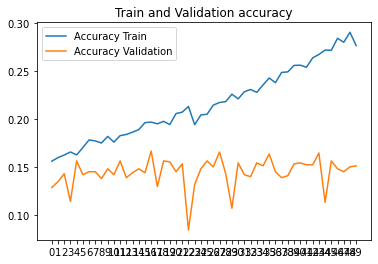

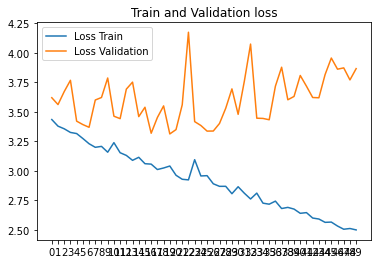

In [63]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(len(accuracy))

plt.plot(num_epochs, accuracy, label='Accuracy Train')
plt.plot(num_epochs, val_accuracy, label='Accuracy Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation accuracy')
plt.show()

plt.plot(num_epochs, loss, label='Loss Train')
plt.plot(num_epochs, val_loss, label='Loss Validation')
plt.legend(loc=0)
plt.xticks(num_epochs)
plt.title('Train and Validation loss')
plt.show()

In [72]:
def mean_avg_top_k(predictions, k=5):
    """Returns the average of the top k (default: k=5) best predictions' index (index equals age in our case)    
    """
    pred_index_list=sorted(((value, key) for (key,value) in enumerate(predictions[0])), reverse=True)
    sorted_index_pred_list=list([(key,value) for value,key in pred_index_list])

    avg = 0
    for i in range(k):
        key, value = sorted_index_pred_list[i]
        avg+=key
    avg/=k
    
    return avg

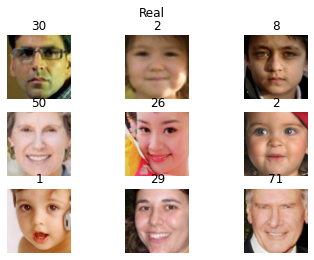

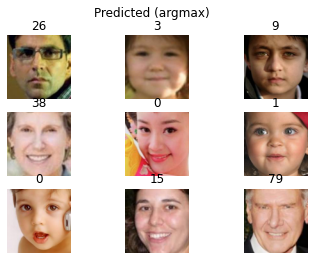

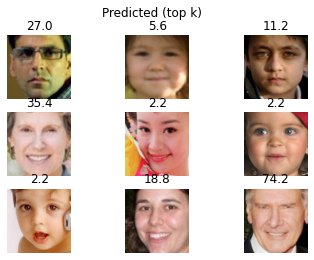

In [73]:
#Show one random image from dataset, including label

example_batch = val_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(y[i].numpy())
    plt.axis("off")
    plt.suptitle("Real")
    
plt.show()    
    
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    best_prediction = np.argmax(predictions)
    #No need to map prediction index to label, because they are identical in our case
    plt.title(best_prediction)
    plt.axis("off")
    plt.suptitle("Predicted (argmax)")
    
plt.show()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    predictions = model.predict(np.expand_dims(x[i], axis=0))
    avg = mean_avg_top_k(predictions)
    plt.title(avg)
    plt.axis("off")
    plt.suptitle("Predicted (top k)")
    
plt.show()


In [74]:
print("Predictions for last example:")
print(predictions)

Predictions for last example:
[[ -2.4522028   -6.4982505   -4.6366286   -6.3952627   -4.589368
   -9.83252     -2.8260212   -1.044286    -5.7347245   -6.345759
   -8.841172    -5.978688    -7.776543    -5.7835183   -7.182777
   -4.4417286   -9.548655    -4.0773616   -9.429755    -7.996274
   -8.439755    -8.280909   -10.191552    -6.7927456   -5.542835
   -6.332715    -5.716585    -4.4493756   -7.0722203   -4.8180246
   -8.482938    -7.3515387  -11.340406    -2.3917196   -8.648798
   -4.1079316   -6.698338    -3.2227597   -4.161762    -5.534804
   -4.857218    -4.499318    -7.4002995   -8.441399    -2.5531223
   -5.883152    -6.5608726   -6.739767    -3.3810415   -3.5967171
   -4.901705    -2.0269666   -1.203361    -5.975994    -5.4337206
   -1.6264621   -1.9350661   -7.441781    -5.6708694   -0.8746807
    0.48925608  -0.7706308   -2.1650262   -3.462138    -2.2092817
   -2.807897    -1.4843646   -1.9711534   -0.79143965  -5.160604
   -3.377428    -2.372263    -4.5000978  -11.120684   

Papers:

* S. N. Kohail:  
Using Artificial Neural Network for Human Age Estimation Based on Facial Images  
2012 International Conference on Innovations in Information Technology (IIT)  
https://www.inf.uni-hamburg.de/en/inst/ab/lt/people/alumni/sarah-kohail/kohail-age-estimation.pdf

* Z. Qawaqneh, A. Abu Mallouh & B. D. Barkana:  
Deep Convolutional Neural Network for Age Estimation based on VGG-Face Model  
https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf

* N. Hewahi, A. Olwan, N. Tubeel, S. El-Asar, Z. Abu-Sultan:  
Age Estimation based on Neural Networks using Face Features  
Journal of Emerging Trends in Computing and Information Sciences 1:2, October 2010  
https://www.researchgate.net/publication/47277288_Age_Estimation_based_on_Neural_Networks_using_Face_Features

* R. Rahadian & S. Suyanto:  
Deep Residual Neural Network for Age Classification with Face Image  
2019 International Seminar on Research of Information Technology and Intelligent Systems (ISRITI)  
https://ieeexplore.ieee.org/document/9034664

* M. M. Islam & J.-H. Baek:  
Deep Learning Based Real Age and Gender Estimation from Unconstrained Face Image towards Smart Store Customer Relationship Management  
Applied Sciences 2021, 11  
https://www.mdpi.com/2076-3417/11/10/4549/pdf

* A. Othmania, A. R. Taleb, H. Abdelkawy & A. Hadid:  
Age estimation from faces using deep learning: A comparative analysis  
Computer Vision and Image Understanding 196, July 2020  
https://www.sciencedirect.com/science/article/abs/pii/S1077314220300424

Additional links:

* https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2